# Introduction to Faster R-CNN  

[Faster R-CNN](https://arxiv.org/abs/1506.01497) (Region-based Convolutional Neural Network) is a **state-of-the-art deep learning framework for object detection**. Unlike simple image classification (which labels an entire image), Faster R-CNN can **identify multiple objects and locate them** precisely with bounding boxes.  

It improves upon earlier R-CNN models by introducing the **Region Proposal Network (RPN)**, which generates candidate object regions directly inside the neural network — making detection both faster and more accurate.  

---

## How Faster R-CNN Works (Intuition)

Faster R-CNN performs object detection in two integrated steps:

1. **Region Proposal Network (RPN):**  
   Suggests candidate “object regions” (anchors) on a feature map produced by a backbone CNN (like [ResNet](https://arxiv.org/abs/1512.03385) or [VGG](https://arxiv.org/abs/1409.1556)).

2. **Fast R-CNN Head:**  
   Classifies each proposed region (what object it is) and refines its bounding box coordinates.

By combining these steps, Faster R-CNN creates an **end-to-end trainable** system that can handle complex images with many objects.

---

## Mathematical Insight

At its core, Faster R-CNN optimizes **two outputs per anchor box**:

- **Classification Probability:**  
  Using a softmax layer, the network predicts the probability of each class for a region:
  $$
  P(\text{class} \mid \text{region})
  $$

- **Bounding Box Regression:**  
  The network predicts offsets to adjust predefined anchor boxes toward the actual object location:
  $$
  t_x = \frac{x - x_a}{w_a}, \quad 
  t_y = \frac{y - y_a}{h_a}, \quad 
  t_w = \log\frac{w}{w_a}, \quad 
  t_h = \log\frac{h}{h_a}
  $$
  where $ x_a, y_a, w_a, h_a $ are anchor box coordinates and \((x,y,w,h)\) are ground-truth box coordinates.  

- **Loss Function:**  
  Faster R-CNN combines classification and regression losses:
  $$L(p_i, t_i) = \frac{1}{N_{\text{cls}}} \sum_i L_{\text{cls}}(p_i, p_i^*) +
  \lambda \frac{1}{N_{\text{reg}}} \sum_i p_i^* L_{\text{reg}}(t_i, t_i^*)$$
  where:
  - $ p_i^* $ is the ground-truth class label (1 for object, 0 for background),
  - $ t_i $ and $ t_i^* $ are predicted and ground-truth bounding box parameters,
  - $ lambda $ balances classification and regression losses.
  - $ p_i $ is the predicted class probability for anchor $ i $,

(See Section 3 of the original [paper](https://arxiv.org/abs/1506.01497) for derivation.)

---

## Applications of Faster R-CNN  

Faster R-CNN is widely used wherever **accurate object detection** is needed:

- **Autonomous Vehicles:** Detect pedestrians, vehicles, traffic signs.  
- **Medical Imaging:** Identify tumors or anomalies in scans.  
- **Retail Analytics:** Detect and classify products on shelves.  
- **Security & Surveillance:** Track people or objects of interest.  
- **Robotics:** Help robots understand and interact with their environment.  

---

## References

- [Ren et al., *Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks* (2015)](https://arxiv.org/abs/1506.01497)  
- [Girshick, *Fast R-CNN* (2015)](https://arxiv.org/abs/1504.08083)  
- [Girshick et al., *Rich Feature Hierarchies for Accurate Object Detection and Semantic Segmentation* (R-CNN) (2014)](https://arxiv.org/abs/1311.2524)  
- [PyTorch torchvision Faster R-CNN docs](https://pytorch.org/vision/stable/models/faster_rcnn.html)  

---

**Key Takeaway:**  
Faster R-CNN is not just an image classifier; it’s a powerful detector that simultaneously answers **“What is it?”** and **“Where is it?”**, enabling countless applications in computer vision.


## Importing Libraries  

In this step, we import the core Python libraries needed for object detection and visualization:

- **torch & torchvision**:  
  Deep learning framework and access to pre-trained Faster R-CNN models.

- **transforms (torchvision.transforms)**:  
  Tools for converting and preprocessing images (e.g., resizing, normalization).

- **requests**:  
  To fetch images directly from the web.

- **cv2 (OpenCV)**:  
  Image processing library (e.g., reading, resizing, manipulating images).

- **numpy**:  
  For numerical operations and handling arrays.

- **PIL (Pillow)**:  
  For opening and manipulating image files in Python.

- **matplotlib.pyplot**:  
  For visualizing images and plotting detection results (bounding boxes, labels).

Together, these libraries provide the foundation for downloading, processing, and visualizing images before applying Faster R-CNN for object detection.


In [1]:
import torch
from torch import no_grad
import torchvision
from torchvision import transforms
import requests
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Helper Function: Filter and Label Predictions  

The Faster R-CNN model outputs raw predictions in the form of:
- **Bounding boxes** (pixel coordinates of detected objects),
- **Labels** (numeric indices corresponding to object categories),
- **Scores** (confidence levels for each detection).  

This helper function $get_predictions$ does the following:
1. **Maps class indices to human-readable names** using the COCO dataset’s category list (`COCO_INSTANCE_CATEGORY_NAMES`).
2. **Filters predictions by confidence threshold** (default = 0.8). Only objects with confidence above this value are kept.
3. **Optionally filters by specific object types** if an `objects` list is provided (e.g., only `"person"` or `"dog"`).  

The function returns a list of tuples with:
- Class name (string),
- Prediction confidence (float),
- Bounding box coordinates `[(x1, y1), (x2, y2)]`.

In [2]:
def get_predictions(pred, threshold=0.8, objects=None):
    """
    Process Faster R-CNN predictions into human-readable labels.

    Args:
        pred (list): Model prediction output. Each element includes:
            - 'labels': class indices,
            - 'scores': confidence scores,
            - 'boxes': bounding box coordinates.
        threshold (float): Minimum confidence required to keep a detection.
        objects (list, optional): Filter results to specific object names.

    Returns:
        list of tuples: Each tuple contains:
            (class_name, confidence_score, bounding_box)
    """
    
    # Convert model output tensors into readable format
    predicted_classes = [
        (COCO_INSTANCE_CATEGORY_NAMES[i], score, [(box[0], box[1]), (box[2], box[3])])
        for i, score, box in zip(
            list(pred[0]['labels'].numpy()),
            pred[0]['scores'].detach().numpy(),
            list(pred[0]['boxes'].detach().numpy())
        )
    ]
    
    # Filter by confidence threshold
    predicted_classes = [item for item in predicted_classes if item[1] > threshold]
    
    # Optional: filter by specific objects
    if objects and predicted_classes:
        predicted_classes = [(name, score, box) for name, score, box in predicted_classes if name in objects]
    
    return predicted_classes

## Helper Function: Draw Bounding Boxes on Detected Objects  

The function $draw_box$ overlays detection results onto an image. It does the following:

1. **Prepares the input image**  
   - Converts the PyTorch tensor (CHW format) into a NumPy array (HWC format).  
   - Scales pixel values to the $[0, 255]$ range.  
   - Converts RGB to OpenCV’s BGR format for drawing.  

2. **Draws bounding boxes**  
   - For each detected object, a rectangle is drawn around its bounding box coordinates.  

3. **Adds labels and confidence scores**  
   - Each bounding box is annotated with the class label and detection confidence.  

4. **Displays the result**  
   - Uses `matplotlib` to visualize the annotated image inline in the notebook.  

This function helps us **see exactly where Faster R-CNN found objects** and how confident it is about each detection.


In [3]:
def draw_box(predicted_classes, image, rect_th=10, text_size=3, text_th=3):
    # Convert tensor to OpenCV image
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()

    for predicted_class in predicted_classes:
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]

        # Ensure coordinates are integers
        pt1 = (int(box[0][0]), int(box[0][1]))
        pt2 = (int(box[1][0]), int(box[1][1]))

        cv2.rectangle(img, pt1, pt2, (0, 255, 0), rect_th)
        text = f"{label}: {round(probability, 2)}"
        cv2.putText(img, text, pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    del img
    del image

## Helper Function: Free Up Memory  

Deep learning models like Faster R-CNN can consume a lot of GPU/CPU memory when processing large images.  
To keep the notebook efficient, we define a utility function $save_RAM$ that:

1. **Clears the CUDA cache**  
   - Uses `torch.cuda.empty_cache()` to release unused GPU memory.  

2. **Deletes large intermediate variables**  
   - Frees `img` (visualized image) and `pred` (model predictions).  

3. **Optionally closes and deletes the input image**  
   - If `image_ = True`, the input PIL image is explicitly closed to prevent memory leaks.  

This helps prevent **out-of-memory errors** when running inference repeatedly on different images.

In [4]:
def save_RAM(image_=False):
    """
    Free up GPU and CPU memory by clearing intermediate variables.

    Args:
        image_ (bool): If True, also closes and deletes the input image.

    Notes:
        - Uses torch.cuda.empty_cache() to clear GPU memory.
        - Deletes large global variables: img, pred, (optionally image).
        - Helpful when running inference multiple times in one session.
    """
    global image, img, pred
    
    # Clear GPU memory cache
    torch.cuda.empty_cache()
    
    # Delete visualization and prediction variables
    if "img" in globals():
        del img
    if "pred" in globals():
        del pred
    
    # Optionally close and delete input image
    if image_ and "image" in globals():
        try:
            image.close()
        except:
            pass
        del image

## Load Pre-trained Faster R-CNN  

Here we load **Faster R-CNN with a ResNet-50 backbone and FPN (Feature Pyramid Network)**, pre-trained on the [COCO dataset](https://cocodataset.org/#home).  

### Key steps:
1. **Load the model**  
   - `torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)` loads a pre-trained detector.  

2. **Freeze the parameters**  
   - We set `requires_grad = False` so that the model’s weights do not update (we are using it only for inference, not training).  

3. **Wrap the model call in a helper function**  
   - The helper `model(x)` runs inference under `torch.no_grad()`, which saves memory and speeds up computation.  

4. **Define COCO category names**  
   - The COCO dataset has **91 categories**, but some are unused (`'N/A'`).  
   - We define the full list in `COCO_INSTANCE_CATEGORY_NAME` so that predictions can be mapped to human-readable labels.  

In [5]:
# Load pre-trained Faster R-CNN (ResNet50 backbone + Feature Pyramid Network)
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()  # Set to evaluation mode

# Freeze model parameters (no training, inference only)
for name, param in model_.named_parameters():
    param.requires_grad = False
print("Model loaded and frozen.")

# Wrap inference call for memory efficiency
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

# COCO dataset class names (91 categories, including '__background__')
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

print(f"Number of COCO classes (including background): {len(COCO_INSTANCE_CATEGORY_NAMES)}")

/home/agasthya/PyTorch_Projects/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/agasthya/PyTorch_Projects/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded and frozen.
Number of COCO classes (including background): 91


## Object Localization with Faster R-CNN  

**Object Localization** means detecting the **presence** of objects in an image and marking their **location** with a bounding box.  

For example, given an image of Geoffrey Hinton, Faster R-CNN will:  
1. Identify candidate objects (e.g., $person$).  
2. Assign likelihood (confidence) scores.  
3. Predict bounding box coordinates: **top (t), left (l), bottom (b), right (r)**.  

We will:  
- Load and preprocess an image.  
- Run inference using the pre-trained Faster R-CNN.  
- Inspect predictions (classes, likelihoods, bounding boxes).  
- Visualize results by drawing bounding boxes.  


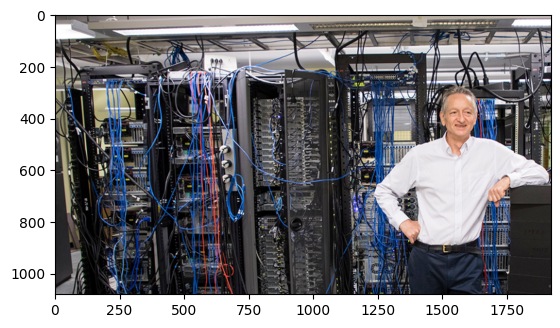

In [6]:
# Load image of Geoffrey Hinton
img_path = 'jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

# Resize for faster processing
image.resize([int(half * s) for s in image.size])

plt.imshow(image)
plt.show()

In [7]:
# Convert image to tensor for Faster R-CNN
transform = transforms.Compose([transforms.ToTensor()])
img = transform(image)

# Run prediction
pred = model([img])  # (uses wrapper to save RAM)

### Inspect Predictions  

Each prediction contains:  
- **Labels** → predicted classes (as integers, referring to COCO categories).  
- **Scores** → likelihood (confidence) for each class.  
- **Boxes** → bounding box coordinates.

We can inspect these outputs:

In [8]:
# Predicted class indices
pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

In [9]:
# Prediction likelihoods (confidence scores)
pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1767, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

In [10]:
# Map first predicted label to COCO category
index = pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

In [11]:
# Bounding box coordinates of first prediction
bounding_box = pred[0]['boxes'][0].tolist()
bounding_box

[1223.1688232421875, 301.24993896484375, 1909.172607421875, 1076.63720703125]

Bounding boxes are given as four coordinates:

$$
(t, l, b, r) = (\text{top}, \text{left}, \text{bottom}, \text{right})
$$

We round them to integers for visualization.

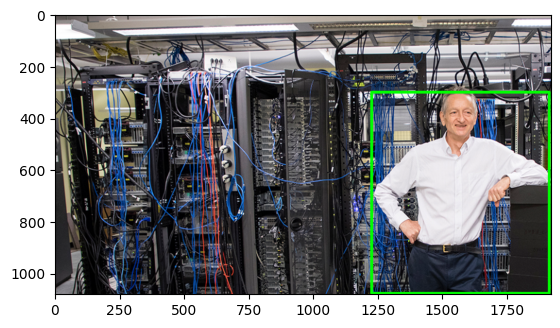

In [12]:
# Round bounding box coordinates
t, l, r, b = [round(x) for x in bounding_box]

# Convert tensor image → OpenCV format
img_plot = (np.clip(
    cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR),
    0, 1) * 255).astype(np.uint8)

# Draw bounding box
cv2.rectangle(img_plot, (t, l), (r, b), (0, 255, 0), 10)
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()

del img_plot, t, l, r, b

### Using Helper Functions  

We can use our helper functions for cleaner localization:  

- `get_predictions(pred, objects, threshold)` → filters predictions by class and confidence.  
- `draw_box(predicted_classes, image)` → draws bounding boxes and labels.  

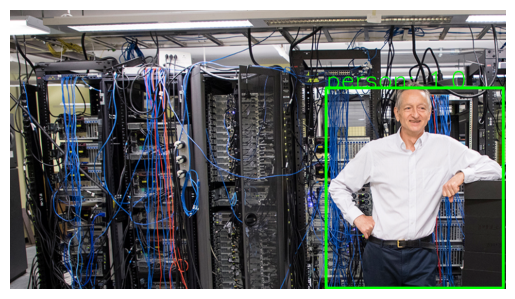

In [13]:
# Detect only 'person' in the image
pred_class = get_predictions(pred, objects="person")
draw_box(pred_class, img)
del pred_class

In [14]:
# Try a strict threshold (100% confidence)
get_predictions(pred, threshold=1, objects="person")

[]

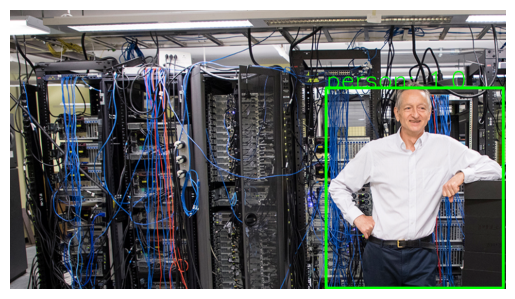

In [15]:
# Relax threshold to 98% confidence
pred_thresh = get_predictions(pred, threshold=0.98, objects="person")
draw_box(pred_thresh, img)
del pred_thresh

In [16]:
# Free memory after inference
save_RAM(image_=True)

## Detecting Multiple Objects  

Let’s now detect multiple people in a group image.  

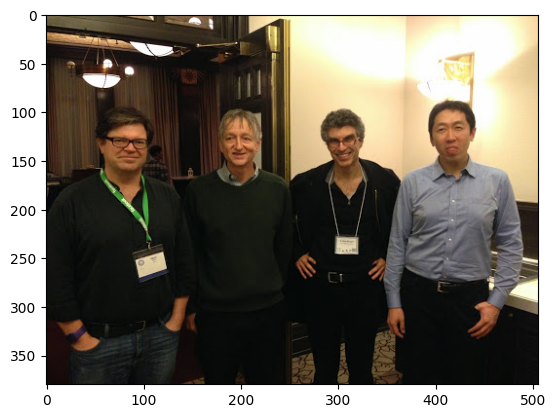

In [17]:
# Load group image
img_path = 'DLguys.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])

plt.imshow(np.array(image))
plt.show()

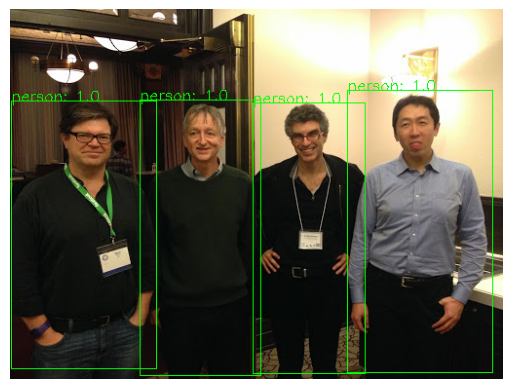

In [18]:
# Run prediction on group image
img = transform(image)
pred = model([img])

# Thresholded detection (0.8 confidence)
pred_thresh = get_predictions(pred, threshold=0.8)
draw_box(pred_thresh, img, rect_th=1, text_size=0.5, text_th=1)
del pred_thresh

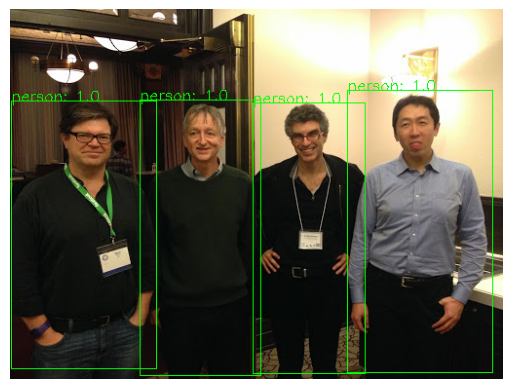

In [19]:
# Detect only persons
pred_obj = get_predictions(pred, objects="person")
draw_box(pred_obj, img, rect_th=1, text_size=0.5, text_th=1)
del pred_obj

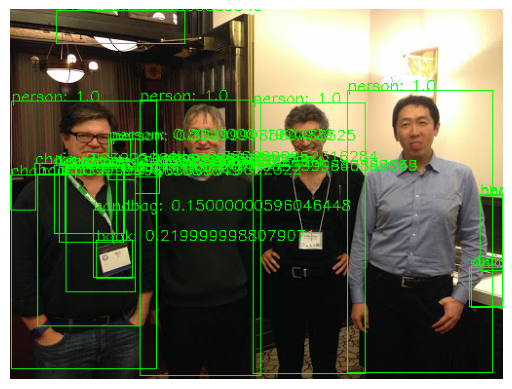

In [20]:
# If threshold too low → false positives appear
pred_thresh = get_predictions(pred, threshold=0.01)
draw_box(pred_thresh, img, rect_th=1, text_size=0.5, text_th=1)
del pred_thresh

In [21]:
# Free memory after inference
save_RAM(image_=True)

## Mathematical View of Object Localization  

In object localization, the model predicts **where** an object is in the image by outputting a **bounding box**.  
This involves **regression** of bounding box coordinates, alongside classification.  

---

### Bounding Box Parameterization  

Faster R-CNN uses **anchor boxes** as reference shapes and predicts offsets to align them with ground-truth boxes.  

If an anchor box has coordinates $(x_a, y_a, w_a, h_a)$ and the ground truth box has $(x, y, w, h)$, the network learns to predict:  

$$
t_x = \frac{x - x_a}{w_a}, \quad
t_y = \frac{y - y_a}{h_a}, \quad
t_w = \log \frac{w}{w_a}, \quad
t_h = \log \frac{h}{h_a}
$$

Here:  
- $(x, y)$ → center of the bounding box  
- $(w, h)$ → width and height  

The predicted offsets $(t_x, t_y, t_w, t_h)$ are applied to anchor boxes to obtain final bounding box proposals.  

---

### Intersection over Union (IoU)  

To evaluate how well a predicted box matches the ground truth, we use **Intersection over Union (IoU)**:

$$
IoU = \frac{\text{Area}(B_\text{pred} \cap B_\text{gt})}{\text{Area}(B_\text{pred} \cup B_\text{gt})}
$$

- $B_\text{pred}$: predicted bounding box  
- $B_\text{gt}$: ground-truth bounding box  

An IoU close to 1.0 means excellent overlap.  

---

### Loss Function  

Faster R-CNN combines **classification loss** and **regression loss** in a single objective:

$$
L(p_i, t_i) = \frac{1}{N_\text{cls}} \sum_i L_\text{cls}(p_i, p_i^*) + 
\lambda \frac{1}{N_\text{reg}} \sum_i p_i^* L_\text{reg}(t_i, t_i^*)
$$

where:  
- $L_\text{cls}$: classification loss (cross-entropy)  
- $L_\text{reg}$: regression loss (smooth L1 for bounding box offsets)  
- $p_i$: predicted class probability  
- $p_i^*$: ground-truth label (1 = object, 0 = background)  
- $t_i, t_i^*$: predicted vs. true bounding box parameters  
- $\lambda$: balancing weight  

In short: **Object Localization = Classification + Bounding Box Regression**, optimized jointly.  

---

### References  

- Shaoqing Ren, Kaiming He, Ross B. Girshick, Jian Sun. *Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks* (2015). [Paper](https://arxiv.org/abs/1506.01497)  
- Tsung-Yi Lin et al. *Microsoft COCO: Common Objects in Context* (2014). [Paper](https://arxiv.org/abs/1405.0312)  
- M. Everingham et al. *The PASCAL Visual Object Classes (VOC) Challenge* (2010). [Paper](http://host.robots.ox.ac.uk/pascal/VOC/)  

## Object Detection with Faster R-CNN  

**Object Detection** extends object localization by not only detecting **where** an object is, but also **what class** it belongs to.  

We will demonstrate detection on several example images, using the pre-trained Faster R-CNN model.  

Key points:  
- Use a **threshold** to filter predictions by likelihood (confidence).  
- Optionally, specify the **objects of interest** to classify specific classes (e.g., "cat" or "dog").  
- Always use `save_RAM()` after inference to free memory.


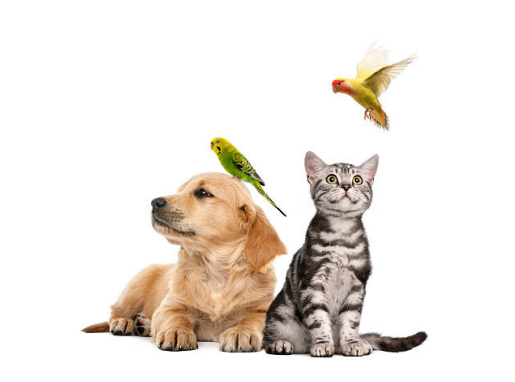

In [22]:
img_path = 'istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)

# Resize image for faster processing
image.resize([int(half * s) for s in image.size])

# Display the image
plt.imshow(np.array(image))
plt.axis("off")
plt.show()
del img_path

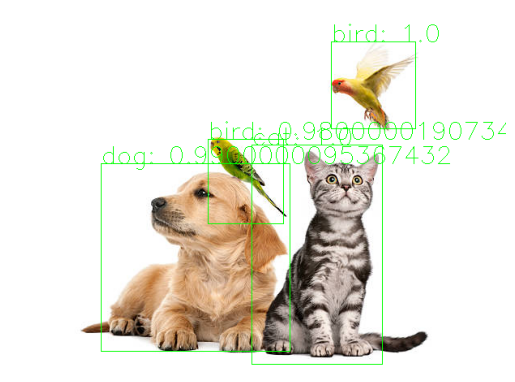

In [23]:
# Convert image to tensor and run prediction
img = transform(image)
pred = model([img])

# Thresholded detection: likelihood > 0.97
pred_thresh = get_predictions(pred, threshold=0.97)
draw_box(pred_thresh, img, rect_th=1, text_size=1, text_th=1)
del pred_thresh

# Free memory
save_RAM(image_=True)

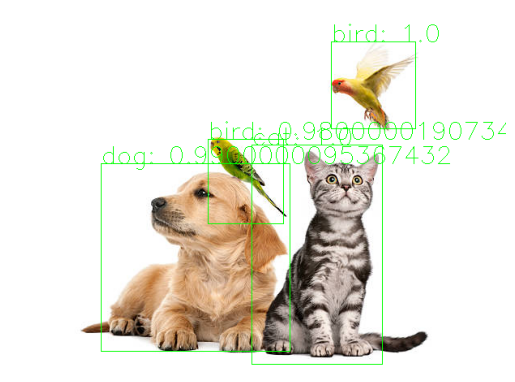

In [28]:
img_path = 'istockphoto-187786732-612x612.jpeg'
image = Image.open(img_path)

# Convert image to tensor and run prediction
img = transform(image)
pred = model([img])

# Thresholded detection: likelihood > 0.97
pred_thresh = get_predictions(pred, threshold=0.97)
draw_box(pred_thresh, img, rect_th=1, text_size=1, text_th=1)
del pred_thresh

# Free memory
# save_RAM(image_=True)

### Detect Specific Classes  

We can focus detection on specific object categories, such as `"cat"` and `"dog"`.  
This helps when you are only interested in a subset of objects in the image.

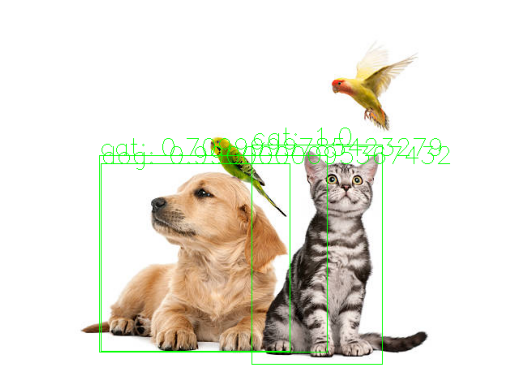

In [29]:
# Low threshold example (0.7) may result in false positives
pred_thresh = get_predictions(pred, threshold=0.70, objects=["dog", "cat"])
draw_box(pred_thresh, img, rect_th=1, text_size=1, text_th=1)
del pred_thresh

# Free memory
# save_RAM(image_=True)

### Detecting Other Objects  

We can detect different types of objects, such as vehicles and airplanes.  
The threshold can be adjusted to balance between missing objects and false positives.

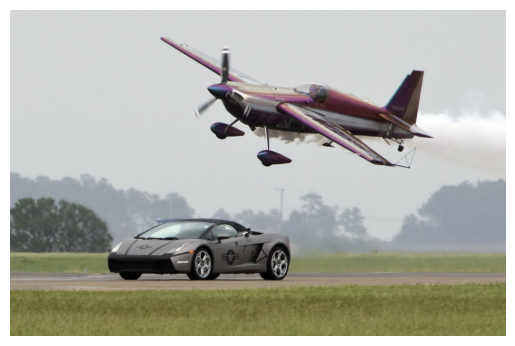

In [30]:
img_path = 'watts_photos2758112663727581126637_b5d4d192d4_b.jpeg'
image = Image.open(img_path)

# Resize and display
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.axis("off")
plt.show()
del img_path

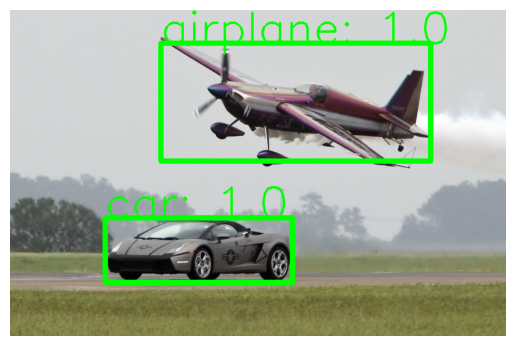

In [31]:
# Convert image to tensor and run prediction
img = transform(image)
pred = model([img])

# High threshold detection
pred_thresh = get_predictions(pred, threshold=0.997)
draw_box(pred_thresh, img)
del pred_thresh

# Free memory
save_RAM(image_=True)

## Test Model With an Uploaded Image  

You can test object detection on any image by either providing a **URL** or uploading an image from your local machine.  

**Important:** The image must have a valid extension like `.jpg` or `.png`.  

### Steps:
1. Load the image (from URL or local file).  
2. Convert the image to RGB and preprocess with `transforms.ToTensor()`.  
3. Run the pre-trained Faster R-CNN model.  
4. Filter predictions using a **likelihood threshold**.  
5. Draw bounding boxes with the detected classes.  
6. Free memory using `save_RAM()`.  

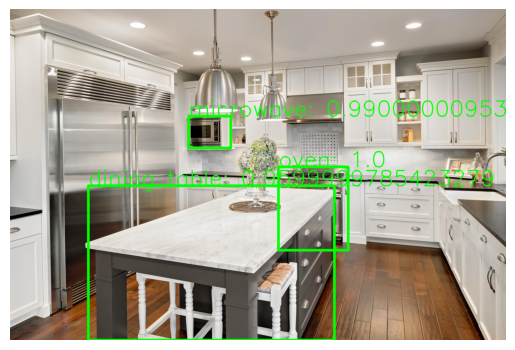

In [32]:
import requests

# Example image URL
url = 'https://www.plastform.ca/wp-content/themes/plastform/images/slider-image-2.jpg'

# Download and convert image to RGB
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
del url

# Transform image and run model
img = transform(image)
pred = model([img])

# Filter predictions with likelihood > 0.95
pred_thresh = get_predictions(pred, threshold=0.95)
draw_box(pred_thresh, img)
del pred_thresh

# Free memory
# save_RAM(image_=True)

### Upload and Detect Objects from Local Image  

1. Use the **Upload button** in Jupyter Notebook to upload your image.  
2. Replace `'your_image_name.jpg'` with the uploaded file name.  

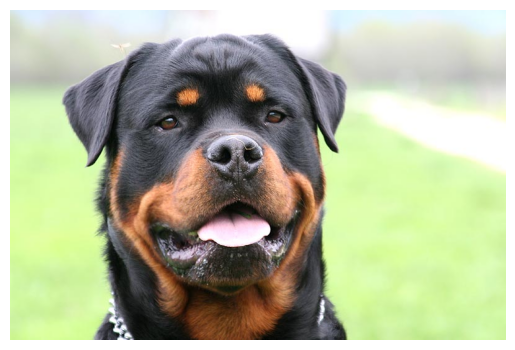

In [36]:
img_path = './rot.jpg'
image = Image.open(img_path)  # Load image
plt.imshow(np.array(image))
plt.axis("off")
plt.show()

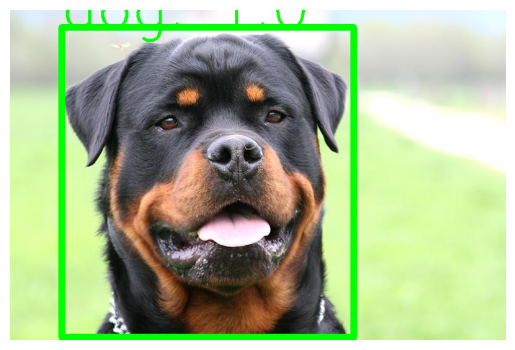

In [37]:
# Convert image to tensor and run prediction
img = transform(image)
pred = model([img])
pred_thresh = get_predictions(pred, threshold=0.95)
draw_box(pred_thresh, img)
del pred_thresh

# Free memory
save_RAM(image_=True)

## References

1. Images were taken from: [https://homepages.cae.wisc.edu/~ece533/images/](https://homepages.cae.wisc.edu/~ece533/images/)  
2. [Pillow Documentation](https://pillow.readthedocs.io/en/stable/)  
3. [OpenCV Documentation](https://opencv.org/)  
4. Gonzalez, Rafael C., and Richard E. Woods. *Digital Image Processing*, 2017.